In [1]:
import torch
from utils import data_loader_multifiles
import h5py
import matplotlib.pyplot as plt
import h5py
from mpi4py import MPI
import numpy as np
import time
from netCDF4 import Dataset as DS
import os
from utils.dataReformatter import writetofile
import utils
from importlib import reload  # Python 3.4+
reload(utils.dataReformatter)


/home/hk-project-epais/ke4365/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/hkfs/home/project/hk-project-epais/ke4365/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


<module 'utils.dataReformatter' from '/hkfs/work/workspace/scratch/ke4365-pangu/pangu-weather/utils/dataReformatter.py'>

In [23]:
df = h5py.File("/hkfs/work/workspace/scratch/ke4365-pangu/FCN_ERA5_data_v0/out_of_sample/2018.h5")
print("shape of data:", df['fields'].shape)
print("Dim 0: n_samples") # samples are (presumably) spaced out by every 6 hours
print("Dim 1: pressure levels???")
print("Dim 2: Longitude")
print("Dim 3: Latitude")
print("variable 21 (index 20) is a land-sea mask")

shape of data: (1460, 21, 721, 1440)
Dim 0: n_samples
Dim 1: pressure levels???
Dim 2: Longitude
Dim 3: Latitude
variable 21 (index 20) is a land-sea mask


In [30]:
src = '/hkfs/work/workspace/scratch/ke4365-pangu/10m_2021_10_19_0.nc'
nc = DS(src, 'r', format="NETCDF4")

In [37]:
(nc['t2m'][:])

(4, 721, 1440)

In [88]:
src = '/hkfs/work/workspace/scratch/ke4365-pangu/10m_2021_10_19_0.nc'
dest = '/hkfs/work/workspace/scratch/ke4365-pangu/10m_2021_10_19_0.h5'
#u10 v10 t2m

writetofile(src, dest, 0, ['msl'])
writetofile(src, dest, 1, ['u10'])
writetofile(src, dest, 2, ['v10'])
writetofile(src, dest, 3, ['t2m'])


fsrc shape (4, 721, 1440)
(4, 721, 1440)
fsrc shape (4, 721, 1440)
(4, 721, 1440)
fsrc shape (4, 721, 1440)
(4, 721, 1440)
fsrc shape (4, 721, 1440)
(4, 721, 1440)


In [7]:
src = '/hkfs/work/workspace/scratch/ke4365-pangu/10m_2021_10_19_0.nc'
dest = '/hkfs/work/workspace/scratch/ke4365-pangu/10m_2021_10_19_0.h5'
h5 = h5py.File(dest)
nc = DS(src, 'r', format="NETCDF4")

## Split up data into input vs output

In [2]:
input_surface_data = h5['fields'][0::2]
output_surface_data = h5['fields'][1::2]

NameError: name 'h5' is not defined

In [2]:
def load_surface_data(path='/hkfs/work/workspace/scratch/ke4365-pangu/10m_2021_10_19_0.h5'):
    h5 = h5py.File(path)
    input_surface_data = h5['fields'][0::2]
    output_surface_data = h5['fields'][1::2]
    return torch.tensor(input_surface_data), torch.tensor(output_surface_data)

In [3]:
input_surface_data, output_surface_data = load_surface_data()

# Access some pressure data from ERA5

In [105]:
c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'geopotential', 'specific_humidity', 'temperature',
            'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '1000','925','850','700','600','500','400','300','250','200','150','100','50',
        ],
        'year': '2021',
        'month': '10',
        'day': [
            '19','20'
        ],
        'time': [
            '00:00', '06:00'
        ],
    },
    '/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.nc'
)

2023-11-29 15:35:17,136 INFO Welcome to the CDS
2023-11-29 15:35:17,137 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-11-29 15:35:17,204 INFO Request is queued
2023-11-29 15:41:35,569 INFO Request is completed
2023-11-29 15:41:35,570 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data7/adaptor.mars.internal-1701268808.5441885-7535-14-34e40efb-8581-46b2-9286-b396673e320c.nc to /hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.nc (514.9M)
2023-11-29 15:42:14,676 INFO Download rate 13.2M/s 


Result(content_length=539895924,content_type=application/x-netcdf,location=https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data7/adaptor.mars.internal-1701268808.5441885-7535-14-34e40efb-8581-46b2-9286-b396673e320c.nc)

In [106]:
#h5 = h5py.File(dest)
# First set of parallelized data
nc = DS('/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.nc', 'r', format="NETCDF4")

In [112]:
# Possible variables: 'z', 'q', 't', u', 'v'
nc.variables['u']


<class 'netCDF4._netCDF4.Variable'>
int16 u(time, level, latitude, longitude)
    scale_factor: 0.0022328726483102977
    add_offset: 25.653134662308656
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: U component of wind
    standard_name: eastward_wind
unlimited dimensions: 
current shape = (4, 13, 721, 1440)
filling on

In [120]:
def writepltofile(src, dest, channel_idx, varslist, src_idx=0, frmt='nc'):
    if os.path.isfile(src):
        batch = 2**4
        
        Nimgtot = 4#src_shape[0]

        Nimg = Nimgtot
        base = 0
        end = Nimgtot
        idx = base

        with h5py.File(dest, 'a') as fdest:
            for variable_name in varslist:
    
                if frmt == 'nc':
                    fsrc = DS(src, 'r', format="NETCDF4").variables[variable_name]
                elif frmt == 'h5':
                    fsrc = h5py.File(src, 'r')[varslist[0]]
                print("fsrc shape", fsrc.shape)

                if 'fields' not in fdest:
                    fdest.create_dataset('fields', shape=(4, 5, 13, 721, 1440), dtype='f') # dims: 4 time points
                                                                            #       5 variables
                                                                            #       13 pressure levels
                                                                            #       721 latitude
                                                                            #       1440 longitude
                
                start = time.time()
                while idx<end:
                    if end - idx < batch:
                        if len(fsrc.shape) == 5:
                            ims = fsrc[idx:end,src_idx, :]
                        else:
                            ims = fsrc[idx:end]
                        print(ims.shape)
                        fdest['fields'][idx:end,  channel_idx, :, :, :] = ims
                        break
                    else:
                        if len(fsrc.shape) == 5:
                            ims = fsrc[idx:idx+batch,src_idx, :]
                        else:
                            ims = fsrc[idx:idx+batch]
                        #ims = fsrc[idx:idx+batch]
                        print("ims shape", ims.shape)
                        fdest['fields'][idx:idx+batch,  channel_idx, :, :, :] = ims
                        idx+=batch
                        ttot = time.time() - start
                        eta = (end - base)/((idx - base)/ttot)
                        hrs = eta//3600
                        mins = (eta - 3600*hrs)//60
                        secs = (eta - 3600*hrs - 60*mins)
    
                ttot = time.time() - start
                hrs = ttot//3600
                mins = (ttot - 3600*hrs)//60
                secs = (ttot - 3600*hrs - 60*mins)
                channel_idx += 1 

In [123]:
writepltofile(src='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.nc',
              dest='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.h5',
              channel_idx=0,
              varslist=['z'])
writepltofile(src='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.nc',
              dest='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.h5',
              channel_idx=1,
              varslist=['q'])

writepltofile(src='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.nc',
              dest='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.h5',
              channel_idx=2,
              varslist=['t'])
writepltofile(src='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.nc',
              dest='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.h5',
              channel_idx=3,
              varslist=['u'])
writepltofile(src='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.nc',
              dest='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.h5',
              channel_idx=4,
              varslist=['v'])


fsrc shape (4, 13, 721, 1440)
(4, 13, 721, 1440)
fsrc shape (4, 13, 721, 1440)
(4, 13, 721, 1440)
fsrc shape (4, 13, 721, 1440)
(4, 13, 721, 1440)
fsrc shape (4, 13, 721, 1440)
(4, 13, 721, 1440)
fsrc shape (4, 13, 721, 1440)
(4, 13, 721, 1440)


In [5]:
# read h5 data
h5 = h5py.File('/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.h5')

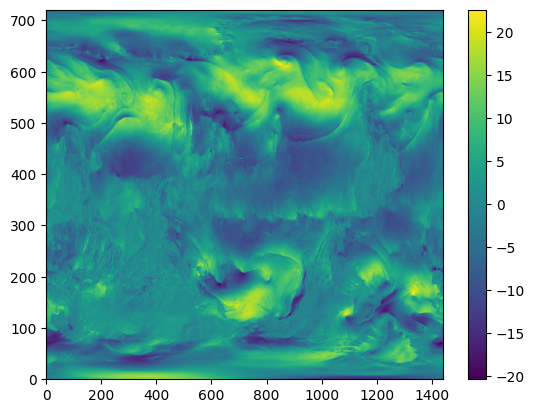

In [6]:
plt.pcolor(h5['fields'][2][3][0])
plt.colorbar()

In [4]:
def load_pressure_data(path='/hkfs/work/workspace/scratch/ke4365-pangu/pl_2021_10_19_0.h5'):
    h5 = h5py.File(path)
    input_pressure_data = h5['fields'][0::2]
    input_pressure_data = h5['fields'][1::2]
    return torch.tensor(input_pressure_data), torch.tensor(input_pressure_data)

In [5]:
input_pressure_data, output_pressure_data = load_pressure_data()

# Train Pangu?

In [6]:
from torch.nn import Linear, Conv3d, Conv2d, ConvTranspose3d, ConvTranspose2d
# Functions in the networks, namely GeLU, DropOut, DropPath, LayerNorm, and Softmax
# GeLU: the GeLU activation function, see Pytorch API or Tensorflow API
# DropOut: the dropout function, available in all deep learning libraries
# DropPath: the DropPath function, see the implementation of vision-transformer, see timm pakage of Pytorch
# A possible implementation of DropPath: from timm.models.layers import DropPath
# LayerNorm: the layer normalization function, see Pytorch API or Tensorflow API
# Softmax: Softmax function, see Pytorch API or Tensorflow API
#from torch.nn import GeLU, DropOut, DropPath, LayerNorm, Softmax
from torch.nn import GELU, Dropout, LayerNorm, Softmax
from networks.Drop import DropPath
from torch import nn
# NOTE: libraries where exact equivalents couldn't be found.
# from torch.nn import DropPath # Should be from timm

# Common functions for roll, pad, and crop, depends on the data structure of your software environment
#from torch.nn import roll3D, pad3D, pad2D, Crop3D, Crop2D
from torch import roll
from torch.nn.functional import pad
from torchvision.transforms.functional import crop

# Common functions for reshaping and changing the order of dimensions
# reshape: change the shape of the data with the order unchanged, see Pytorch API or Tensorflow API
# transpose: change the order of the dimensions, see Pytorch API or Tensorflow API
from torch import reshape, transpose, permute

# Common functions for creating new tensors
# ConstructTensor: create a new tensor with an arbitrary shape
# TruncatedNormalInit: Initialize the tensor with Truncate Normalization distribution
# RangeTensor: create a new tensor like arange(a, b)
#from Your_AI_Library import ConstructTensor, TruncatedNormalInit, RangeTensor
from torch import arange, zeros
# ConstructTensor, TruncatedNormalInit

# Common operations for the data, you may design it or simply use deep learning APIs default operations
# linspace: a tensor version of numpy.linspace
# MeshGrid: a tensor version of numpy.meshgrid
# Stack: a tensor version of numpy.stack
# Flatten: a tensor version of numpy.ndarray.flatten
# TensorSum: a tensor version of numpy.sum
# TensorAbs: a tensor version of numpy.abs
# Concatenate: a tensor version of numpy.concatenate
from torch import linspace, meshgrid, stack, flatten, sum, abs, concat


In [21]:
from networks.pangu import PanguModel
import networks
import networks.Drop
import DataLoader
reload(networks.pangu)
reload(networks.Drop)
DataLoader = reload(DataLoader)

In [27]:
import gc 
gc.collect()

0

In [23]:
model = PanguModel()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=3e-6)
loss1 = nn.L1Loss()
loss2 = nn.L1Loss()

folder path!  constant_masks/


In [24]:
# Train single Pangu-Weather model
epochs = 100
for i in arange(epochs):
    # For each epoch, we iterate from 1979 to 2017
    # dataset_length is the length of your training data, e.g., the sashapemple between 1979 and 2017
    for step in arange(2):
      # Load weather data at time t as the input; load weather data at time t+1/3/6/24 as the output
      # Note the data need to be randomly shuffled
      # Note the input and target need to be normalized, see Inference() for details
      optimizer.zero_grad()
        
      input, input_surface, target, target_surface = input_pressure_data, input_surface_data, output_pressure_data, output_surface_data

      # Call the model and get the output
      output, output_surface = model(input, input_surface)

      # We use the MAE loss to train the model
      # The weight of surface loss is 0.25
      # Different weight can be applied for differen fields if needed
      loss = 0.75 * loss1(output, target) + 0.25 * loss2(output_surface, target_surface) # idk probably need a 75% weighting lol
      # Call the backward algorithm and calculate the gratitude of parameters
      loss.backward()

      # Update model parameters with Adam optimizer
      # The learning rate is 5e-4 as in the paper, while the weight decay is 3e-6
      # A example solution is using torch.optim.adam
      optimizer.step()

input surface shape beforehand torch.Size([2, 4, 721, 1440])
input surface shape afterwards torch.Size([2, 4, 724, 1440])
land mask shape torch.Size([724, 1440])
x orign torch.Size([2, 8, 360, 181, 192])
x orign torch.Size([2, 8, 360, 181, 192])
y, z padding (0, 0, 0, 1)
x orign torch.Size([2, 8, 180, 91, 384])
x orign torch.Size([2, 8, 180, 91, 384])
x orign torch.Size([2, 8, 180, 91, 384])
x orign torch.Size([2, 8, 180, 91, 384])
x orign torch.Size([2, 8, 180, 91, 384])
x orign torch.Size([2, 8, 180, 91, 384])
upsampling
x orign torch.Size([2, 8, 360, 181, 192])
x orign torch.Size([2, 8, 360, 181, 192])
skip dim: torch.Size([2, 521280, 192])
x dim: torch.Size([2, 521280, 192])
x shape before convtranspose3d torch.Size([2, 521280, 384])
current output shape torch.Size([2, 5, 14, 724, 1440])
current output surface shape torch.Size([2, 4, 724, 1440])
after cropping, output shape torch.Size([2, 5, 13, 721, 1440])
after cropping, output surface shape torch.Size([2, 4, 721, 1440])
input su

KeyboardInterrupt: 

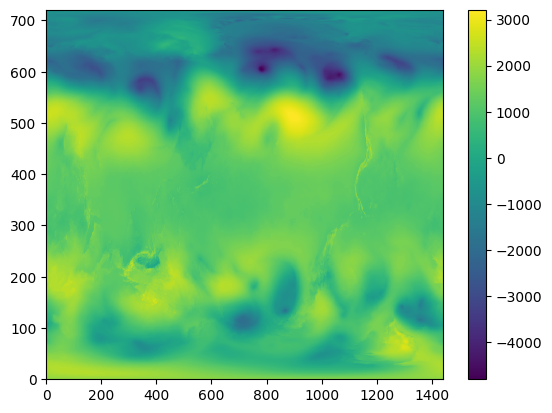

In [34]:
plt.pcolor(target[0][0][0])
plt.colorbar()

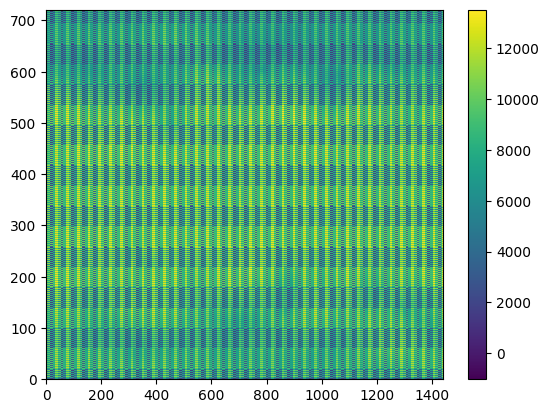

In [25]:
plt.pcolor(output.detach().numpy()[0][0][0])
plt.colorbar()

In [26]:
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[[[[ 0.0445, -0.0153,  0.0572,  0.0570],
           [ 0.0049, -0.0508,  0.0313,  0.0129],
           [-0.0700,  0.0308, -0.0538,  0.0341],
           [ 0.0711, -0.0403,  0.0695,  0.0426]],

          [[ 0.0010, -0.0154,  0.0061,  0.0610],
           [ 0.0016, -0.0294, -0.0610,  0.0006],
           [ 0.0530, -0.0064,  0.0483,  0.0200],
           [ 0.0764, -0.0305,  0.0708,  0.0628]]],


         [[[-0.0040, -0.0508, -0.0761,  0.0310],
           [-0.0310,  0.0174,  0.0697, -0.0790],
           [ 0.0623,  0.0785, -0.0667, -0.0675],
           [ 0.0746,  0.0299,  0.0473,  0.0043]],

          [[ 0.0151,  0.0699, -0.0262,  0.0213],
           [ 0.0205,  0.0643, -0.0105,  0.0372],
           [ 0.0442, -0.0295,  0.0409,  0.0544],
           [-0.0769, -0.0426,  0.0078, -0.0090]]],


         [[[ 0.0467, -0.0020, -0.0383, -0.0315],
           [-0.0504,  0.0350, -0.0147, -0.0640],
           [ 0.0003,  0.0405, -0.0677,  0.0634],
           [ 0.0255,  0.0224,  0.04

In [ ]:
B_ = 41
N  = 16
H  = 23
W  = 29
C  = 6
h  = 2
M  = 4

x  = torch.zeros(B_, N, C)

q, k, v = torch.zeros((3, B_, h, N, C//h))
print("x shape before", x.shape, "= B_, N, C")
print("Q shape, ", q.shape, "= B_, h, N, C//h")
attn = (q @ k.transpose(-2, -1))  @ v
print("QKV shape, ", attn.shape, "= B_, h, N, C//h")

x    = attn.transpose(1, 2).reshape((B_, -1, C))
print("x shape end", x.shape, B_, N, C//h)

In [316]:
x = torch.rand([2, 521280, 192])
layernorm = torch.nn.LayerNorm(192)

In [318]:
layernorm(x).shape

torch.Size([2, 521280, 192])

In [228]:
x1 = torch.zeros([2, 521280, 192])
x2 = torch.zeros([2, 521280, 192])

In [231]:
torch.cat((x1, x2), dim=2).shape

torch.Size([2, 521280, 384])